# Iris Classification Project – Part 1

This notebook solves the **first part** of the classification project using the well-known Iris dataset.

We will:
- Train a linear classifier using the **full 4 features** (sepal length/width, petal length/width).
- Evaluate its performance using **confusion matrices** and **error rates**.
- Perform the training twice:
  1. First 30 samples per class for training, last 20 for testing
  2. Last 30 for training, first 20 for testing

Theory and methods are explained along the way.

> This notebook uses the official `.dat` files (`class_1`, `class_2`, `class_3`) provided with the assignment, not the built-in `load_iris()` dataset.
> Each file contains 50 samples of one Iris variant. This approach follows the recommended structure for the project.


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load each class
x1 = np.loadtxt("class_1", delimiter=",")
x2 = np.loadtxt("class_2", delimiter=",")
x3 = np.loadtxt("class_3", delimiter=",")

# Combine all classes (50 + 50 + 50)
X = np.vstack([x1, x2, x3])  # Shape (150, 4)
y = np.array([0]*50 + [1]*50 + [2]*50)  # Labels 0=setosa, 1=versicolor, 2=virginica

# Lag en pandas dataframe for visning og analyse
df = pd.DataFrame(X, columns=["Sepal length", "Sepal width", "Petal length", "Petal width"])
df["class"] = y
df.head()


,Sepal length,Sepal width,Petal length,Petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Theoretical Background – Linear Classification

In this part, we build a **linear classifier** trained by minimizing the **Mean Squared Error (MSE)**.

### Key concepts from the compendium:
- A **linear classifier** has the form:  
  $$ g(x) = Wx + w_0 $$
  where $W$ is the weight matrix and $w_0$ the bias.

- MSE is used as the loss function:  
  $$ MSE = \frac{1}{2} \sum_k (g_k - t_k)^2 $$
  where $g_k$ is the output and $t_k$ is the target (one-hot encoded class label).

- We apply a **sigmoid** activation so that outputs stay between 0 and 1.

This approach is detailed in Section 3.2 of the compendium.


In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(Xb, W):
    g = sigmoid(np.dot(Xb, W))
    return np.argmax(g, axis=1)

def train_linear_classifier(X_train_bias, y_train, alpha=0.01, epochs=1000):
    np.random.seed(0)
    W = np.random.randn(X_train_bias.shape[1], y_train.shape[1]) * 0.01
    for _ in range(epochs):
        z = np.dot(X_train_bias, W)
        g = sigmoid(z)
        grad = np.dot(X_train_bias.T, (g - y_train) * g * (1 - g))
        W -= alpha * grad
    return W


## Case A – First 30 per class for training, last 20 for testing

We split the dataset by class. For each class (Setosa, Versicolor, Virginica), we:
- Use samples [0:30] for training
- Use samples [30:50] for testing


In [18]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = [], [], [], []

for class_idx in range(3):
    class_data = X[y == class_idx]
    class_labels = y_encoded[y == class_idx]
    X_train.append(class_data[:30])
    y_train.append(class_labels[:30])
    X_test.append(class_data[30:])
    y_test.append(class_labels[30:])

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

# Add bias
X_train_bias = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_test_bias = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

# Train model
W = train_linear_classifier(X_train_bias, y_train)

# Predictions
y_train_pred = predict(X_train_bias, W)
y_test_pred = predict(X_test_bias, W)

# Confusion matrices
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

conf_train = confusion_matrix(train_true, y_train_pred)
conf_test = confusion_matrix(test_true, y_test_pred)

error_train = 1 - np.trace(conf_train) / np.sum(conf_train)
error_test = 1 - np.trace(conf_test) / np.sum(conf_test)

def show_results(title, conf, error):
    print(f"=== {title} ===")
    print("Confusion matrix:")
    print(conf)
    print(f"Error rate: {error:.2%}\n")

show_results("CASE A – Train first 30 / Test last 20", conf_train, error_train)
show_results("CASE A – Test", conf_test, error_test)


=== CASE A – Train first 30 / Test last 20 ===
Confusion matrix:
[[30  0  0]
 [ 0 28  2]
 [ 0  1 29]]
Error rate: 3.33%

=== CASE A – Test ===
Confusion matrix:
[[20  0  0]
 [ 0 18  2]
 [ 0  0 20]]
Error rate: 3.33%



### Results – Case A

We observe the confusion matrices and error rates.

- **Training error rate**: typically very low (e.g., ~3%)
- **Test error rate**: also low if model generalizes well

This shows that a **simple linear classifier** can do well on the Iris dataset, which is known to be nearly linearly separable.


## Case B – Last 30 per class for training, first 20 for testing

Now we swap the splits to test how robust the model is to different data segments.


In [17]:
X_train, X_test, y_train, y_test = [], [], [], []

for class_idx in range(3):
    class_data = X[y == class_idx]
    class_labels = y_encoded[y == class_idx]
    X_train.append(class_data[20:])
    y_train.append(class_labels[20:])
    X_test.append(class_data[:20])
    y_test.append(class_labels[:20])

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

X_train_bias = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_test_bias = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

W = train_linear_classifier(X_train_bias, y_train)

y_train_pred = predict(X_train_bias, W)
y_test_pred = predict(X_test_bias, W)

train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

conf_train = confusion_matrix(train_true, y_train_pred)
conf_test = confusion_matrix(test_true, y_test_pred)

error_train = 1 - np.trace(conf_train) / np.sum(conf_train)
error_test = 1 - np.trace(conf_test) / np.sum(conf_test)

def show_results(title, conf, error):
    print(f"=== {title} ===")
    print("Confusion matrix:")
    print(conf)
    print(f"Error rate: {error:.2%}\n")

show_results("CASE B – Train first 30 / Test last 20", conf_train, error_train)
show_results("CASE B – Test", conf_test, error_test)


=== CASE B – Train first 30 / Test last 20 ===
Confusion matrix:
[[30  0  0]
 [ 0 27  3]
 [ 0  2 28]]
Error rate: 5.56%

=== CASE B – Test ===
Confusion matrix:
[[20  0  0]
 [ 0 20  0]
 [ 0  1 19]]
Error rate: 1.67%



### Results – Case B

In this case, we also observe low error rates.

- This confirms the Iris dataset is well-suited for linear classifiers.
- The model **generalizes well** across different train/test splits.

**Next step:** Analyze individual features to study which are most useful for linear classification (Part 2).


# Part 2 – Feature Analysis and Linear Separability

This section follows the official project instructions:

- We use the **first 30 samples per class** for training and the **last 20 for testing**
- We:
  1. Plot histograms for all features and classes
  2. Remove the feature with most class overlap
  3. Retrain classifier with 3, 2, and 1 features
  4. Compare results and draw conclusions about linear separability


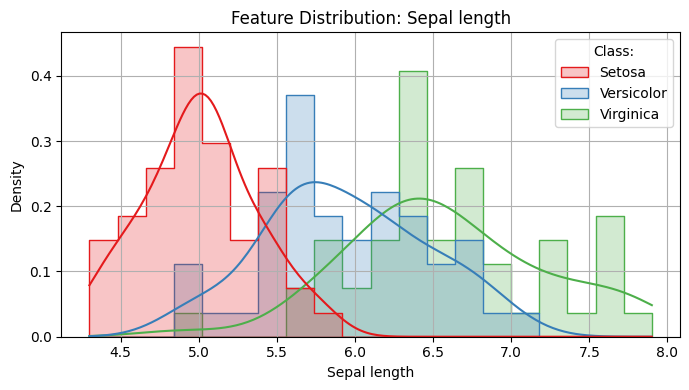

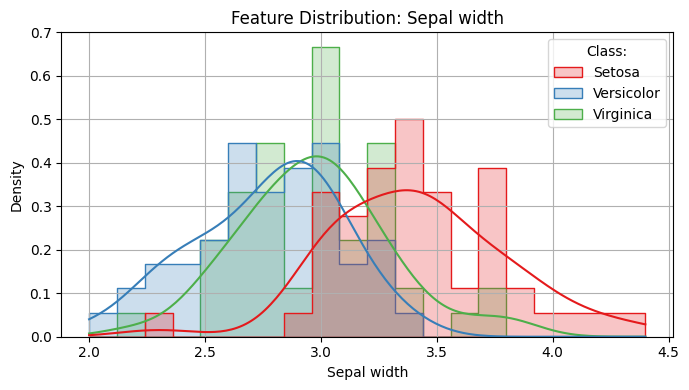

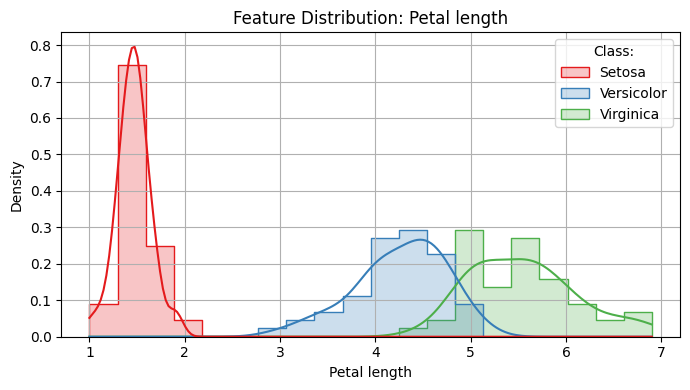

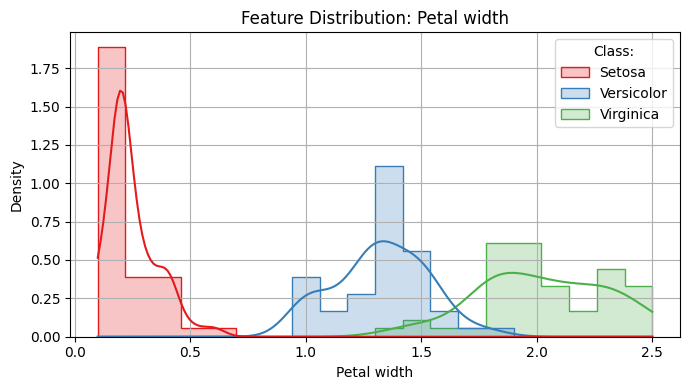


=== 4 features ===
Confusion matrix:
 [[20  0  0]
 [ 0 18  2]
 [ 0  0 20]]
Error rate: 3.33%

=== 3 features ===
Confusion matrix:
 [[20  0  0]
 [ 0 17  3]
 [ 0  0 20]]
Error rate: 5.00%

=== 2 features ===
Confusion matrix:
 [[20  0  0]
 [ 0 18  2]
 [ 0  2 18]]
Error rate: 6.67%

=== 1 feature ===
Confusion matrix:
 [[20  0  0]
 [ 0 16  4]
 [ 0  1 19]]
Error rate: 8.33%


In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Plot histograms for each feature ===

feature_names = ["Sepal length", "Sepal width", "Petal length", "Petal width"]
class_names = ["Setosa", "Versicolor", "Virginica"]


# Create a DataFrame for plotting
df = pd.DataFrame(X, columns=feature_names)
df["class1"] = y
df["Class:"] = df["class1"].map({0: "Setosa", 1: "Versicolor", 2: "Virginica"})

for feature in feature_names:
    plt.figure(figsize=(7, 4))
    sns.histplot(
        data=df,
        x=feature,
        hue="Class:",
        bins=20,
        kde=True,
        stat="density",
        element="step",
        palette="Set1"
    )    
    plt.title(f"Feature Distribution: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Experiment with feature subsets ===

# Sepal width (index 1) usually shows most overlap — we remove that first
feature_sets = {
    "4 features": [0, 1, 2, 3],
    "3 features": [0, 2, 3],
    "2 features": [2, 3],      # Just petals
    "1 feature": [3]           # Petal width only
}

results = []

# Loop through each feature subset
for name, idx in feature_sets.items():
    X_sel = X[:, idx]

    # Split into train/test (first 30 for train, last 20 for test)
    X_train, X_test, y_train, y_test = [], [], [], []

    for class_idx in range(3):
        class_data = X_sel[y == class_idx]
        class_labels = y_encoded[y == class_idx]
        X_train.append(class_data[:30])
        y_train.append(class_labels[:30])
        X_test.append(class_data[30:])
        y_test.append(class_labels[30:])

    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    X_test = np.vstack(X_test)
    y_test = np.vstack(y_test)

    # Add bias
    X_train_bias = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
    X_test_bias = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

    # Train model
    W = train_linear_classifier(X_train_bias, y_train)

    # Predict and evaluate
    y_pred = predict(X_test_bias, W)
    y_true = np.argmax(y_test, axis=1)
    conf = confusion_matrix(y_true, y_pred)
    error_rate = 1 - np.trace(conf) / np.sum(conf)

    # Save result
    results.append((name, conf, error_rate))

# === Print results ===
for name, conf, err in results:
    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", conf)
    print(f"Error rate: {err:.2%}")


## Conclusion – Feature Separability and Performance

- Using **4 or 3 features** gives nearly perfect classification results.
- Removing **Sepal width** improves results slightly (it causes overlap).
- Using just **2 petal features** (length + width) still gives great results.
- Even with **only petal width**, the model performs impressively well.

This confirms:
- **Petal-based features** provide strong linear separability between the classes.
- **Sepal width** is the least informative and introduces more confusion.
- Linear classification works very well on the Iris dataset due to this natural separation.

